### 🚀 프리온보딩코스 Team4 국민연금 DB를 활용한 유니콘 기업 분석

1. 분석 배경 및 방향성 설정 

    > 원티드의 비지니스 모델 및 분석 목적, 의의
    >
    > 실제 유니콘 등재 기업 데이터 특징 바탕으로 분석 방향성 설정

2. 데이터 전처리
3. EDA 1차 : Feature별 기술통계량, 분포, 상관관계, 매출액그룹핑
4. EDA 2차 : 매출액/직원수 필터링 후 feature 분포 파악
5. **Feature selection**
6. **회사별 유니콘 지수(P_unicorn)** 산출 

    > 6-1. 유니콘 지수 기반유니콘 기업 선정
    >
    > 6-2. Clustering을 통한 4의 결과 cross check

7. Team 4 최종 유니콘 기업 선정 (6-1,6-2 결과 교집합)

#### 분석 환경 setting

##### 모듈 import

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Hierarchical clustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

##### PC setting

In [44]:
%matplotlib inline
sns.set_style(style="white")
# (Windows OS) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
# (MAC OS)
#plt.rcParams['font.family'] = 'AppleGothic'  
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False
# 경고 제거
plt.rcParams.update({'figure.max_open_warning': 0})
# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format

##### Load Data

In [4]:
# 데이터 파일 read (각자의 경로 입력)
wanted_nps_df=pd.read_csv('../../company_nps_data.csv', encoding = 'CP949')

## 분석 목적 및 방향성 설정
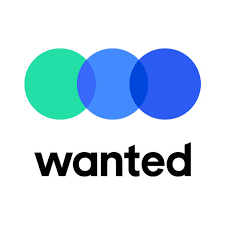
- wanted :구직자와 기업을 매칭하여 채용이 성사된 건에 대해 수수료를 받는 비즈니스 모델
- 연매출액, 월별 연금보험료, 월별 직원수 등 현재 보유한 정보를 가지고 지속적으로 매출 및 채용 수요가 증가하는 유니콘 기업을 선별하고, 해당 기업의 소개 콘텐츠 및 채용 공고 등을 wanted 플랫폼에서 적극적으로 유통한다면 플랫폼 사용자 만족도 개선과 채용 건수 증가에 도움이 될 것으로 보인다.

---

**유니콘 기업의 사전적 정의**
- **유니콘 기업**의 사전적 정의 : 기업 가치 1조원 이상의 비상장 스타트업
- 기업 가치 평가 기준 : 시장 규모와 시장점유율, 현금 유동성, 기술 혁신성, 대표의 야망 등을 종합적 평가

### ⚡ 유니콘 기업 선정 분석 방향성 설정
1. 연매출액, 월별 연금보험료, 월별 직원 수 데이터만으로 사전적 정의대로 유니콘 기업을 선정하기에 어려움이 있으므로, **실제 유니콘 기업 데이터 바탕으로 유니콘 기업의 재정의** 함

2. 유니콘 기업을 선정할 수 있는 척도로서, **유니콘 지수(스코어링)를 위한 Feature Selection** 을 진행함
---
**분석 방향성 정리**
> 1. 실제 유니콘 기업 데이터 특징을 바탕으로 **유니콘 기업 재정의** 
> 2. EDA을 바탕으로 Feature selection 
> 3. 선정된 Feature로 **회사별 유니콘 지수(P_unicorn)** 산출 및 유니콘 기업 선정
> 4. 클러스터링을 통한 Cross check

###  유니콘 기업으로 선정된 기업 정보 수집
- 출처 : https://www.data.go.kr/data/3046071/fileData.do
- 수집 대상 기업 : 비바리퍼블리카, 쏘카, 무신사, 크래프톤, 야놀자, 에이프로젠, 지피클럽
- 수집 대상 기간 : 2015-2019년 (매년 12월 데이터)

In [ ]:
unicorn2019 = pd.read_csv("국민연금 가입 사업장 내역 2019년 12월.csv", encoding='cp949')
unicorn2018 = pd.read_csv("국민연금 가입 사업장 내역 2018년 12월.csv", encoding='cp949')
unicorn2017 = pd.read_csv("국민연금 가입 사업장 내역 2017년 12월.csv", encoding='cp949')
unicorn2016 = pd.read_csv("국민연금 가입 사업장 내역 2016년 12월.csv", encoding='cp949')
unicorn2015 = pd.read_csv("국민연금 가입 사업장 내역 2015년 12월.csv", encoding='cp949')

df_unicorn=pd.DataFrame()
unicorn_list = ['비바리퍼블리카$', '쏘카', '주식회사 무신사', '크래프톤', '.주.야놀자$', '.주.에이프로젠$', '지피클럽']
for i in unicorn_list :
    df_unicorn = df_unicorn.append(unicorn2019[unicorn2019['사업장명 WKPL_NM\tVARCHAR(100)'].str.contains(i)])
    df_unicorn = df_unicorn.append(unicorn2018[unicorn2018['사업장명 WKPL_NM\tVARCHAR(100)'].str.contains(i)])
    df_unicorn = df_unicorn.append(unicorn2017[unicorn2017['사업장명 WKPL_NM\tVARCHAR(100)'].str.contains(i)])
    df_unicorn = df_unicorn.append(unicorn2016[unicorn2016['사업장명 WKPL_NM\tVARCHAR(100)'].str.contains(i)])
    df_unicorn = df_unicorn.append(unicorn2015[unicorn2015['사업장명 WKPL_NM\tVARCHAR(100)'].str.contains(i)])

# 불필요한 컬럼 제거 및 인덱스 리셋
df_unicorn.drop(df_unicorn.filter(regex='주소|가입상태|우편번호|등록번호|등록일자|사업장업종코드 WKPL|탈퇴일자|구분코드').columns , axis=1, inplace=True)
df_unicorn = df_unicorn.reset_index().drop('index', axis=1)

# 컬럼명 재지정
unicorn_newcol = ['년월','사업장명','업종', '적용일자', '직원수', '연금보험료', '신규취득자수','상실가입자수' ]
df_unicorn.columns = unicorn_newcol

# 연도, 월 컬럼 생성
df_unicorn[['년도','월']]=pd.DataFrame(df_unicorn['년월'].str.split('-',2).tolist())
df_unicorn.drop(['년월','월'], axis=1, inplace=True)
df_unicorn['년도'] = df_unicorn['년도'].astype('int64')

# 7개 유니콘 기업 기본 정보 (trend 파악용)
df_unicorn.to_csv('유니콘기업정보.csv')

![실제 유니콘 기업](https://i.esdrop.com/d/BzPR8Oym5h.png)

### ⚡ 유니콘 기업 재정의 
**실제 유니콘 등재 기업 데이터 분석 결과**

> 1. 매출액, 직원수 분포에는 다소 차이가 있었으나, 연매출액이 폭발적으로 성장한 구간이 있었고 직원수 및 연금보험료 또한 성장세를 보였다는 공통점이 있었음 ⇒ "**Feature별 성장률에 집중**"
> 2. 유니콘 기업의 등재 시점 기준 당시 연매출액은 1,000억원 이상 ⇒ "**연매출액 기준 필터링**"

## 데이터 전처리
* 직원이 0명인 경우 제외
* 연매출액이 마이너스인 경우 제외
* **1인당 매출액** 컬럼 추가 : 직원별로 매출에 기여하는 정도를 평가

In [68]:
# 이상치 제외
wanted_nps_df = wanted_nps_df.drop(index=wanted_nps_df.query('연매출액 < 0').index)
wanted_nps_df = wanted_nps_df.drop(index=wanted_nps_df.query('월별_직원수 == 0').index)

# 직원 1인당 매출액 컬럼 추가
wanted_nps_df['인당_매출액'] = wanted_nps_df.loc[:, '연매출액'] / wanted_nps_df.loc[:, '월별_직원수']

# 회사ID 고유 건수
print("전처리 후 기업 수: ", len(set(wanted_nps_df['회사ID'])))

# 데이터의 통계량
wanted_nps_df.describe()

전처리 후 기업 수:  4998


,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,인당_매출액
count,99776.00,99776.00,99776.00,99776.00,99776.00,99776.00,99776.00
mean,276263.21,30544049.77,2016.97,6.71,9736289.82,37.63,594450.03
std,133891.07,301701995.99,0.98,3.51,43477779.16,146.96,1477181.20
min,63.00,300.00,2015.00,1.00,90000.00,3.00,75.00
25%,165530.00,1409955.00,2016.00,4.00,1181815.00,6.00,141982.53
50%,259149.00,3573585.00,2017.00,7.00,2334120.00,11.00,286197.50
75%,382651.00,9592327.00,2018.00,10.00,5592145.00,24.00,586500.00
max,5159723.00,11328779396.00,2019.00,12.00,978067260.00,3133.00,50784748.67


## EDA 1차 
(매출액, 직원 수 기준 필터링 전)

> **목적 : feature간 관계, 분포 확인 및 매출액 필터링 기준 선정(1.1.2의 결론)**

###  데이터 개요
1. 기술 통계량
2. feature 별 상관관계
3. 분포

#### 기술 통계량
(전처리 후) 
> * 4998개 기업의 2015년~2019년까지의 데이터 (날짜는 기업별 상이)
* (참고) 각 Row 기준의 통계 / 회사, 일자 구분 X

>- 최대 연매출액: 약 11조 3천억원
- 최대 월별 연금보험료: 약 9억 7천만원
- 최대 월별 직원수: 약 3100명

>- 평균 연매출액: 약 300억원
- 평균 월별 연금보험료: 약 970만원
- 평균 월별 직원수: 약 37명

>- 최소 연매출액: 약 30만원
- 최소 월별 연금보험료: 약 9만원
- 최소 월별 직원수: 3명

##### 월별 직원수 max 3000

> 1000명 이상 이미 성장한 기업 아닐까? 1000명 이상이면 중견기업으로 유니콘 기업 선정 시 제외 

In [152]:
wanted_nps_df.query('월별_직원수>1000').groupby('회사ID').mean().filter(regex='매출|월별')

,연매출액,월별_연금보험료,월별_직원수,인당_매출액
회사ID,,,,
63,11328779396.00,408529693.33,1010.67,11209424.55
126516,494513588.52,590472073.04,1611.74,305547.06
126521,561140126.16,532062027.89,1526.95,367950.85
126538,698283164.26,396866791.05,1256.47,556106.27
126606,980566803.00,343584450.00,1006.50,974234.52
227414,4567377417.42,869685058.42,2324.05,1963391.79
227415,5314558497.37,852418842.63,2298.42,2312089.95
294337,203081831.53,357223875.26,1736.53,114611.41
294367,875661976.00,328258880.00,1071.08,818304.45


#### feature간 상관관계

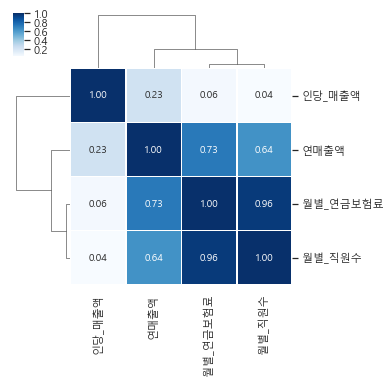

In [77]:
sns.clustermap(data=wanted_nps_df.filter(regex='월별|매출|직원')..corr(),
            annot=True,
            annot_kws={'size': 10},
            fmt='.2f',
            linewidths='.5',
            cmap='Blues', figsize=(5, 5))

- 클러스터맵 

> 연매출액, 월별 연금보험료, 월별 직원수 간 상관관계 매우 높음
>
> 연매출액에서 파생된 변수 인당_매출액의 경우, 매출액과 상관관계 낮음 
>
> (매출액은 연단위 직원수는 월단위로 데이터가 존재하기 때문에 월별_직원수의 변화에 영향을 받은 것으로 추측됨)

#### 분포
- 값이 작은 회사가 압도적으로 많기 때문에 전체적인 내용 확인을 위해 값에 log를 적용

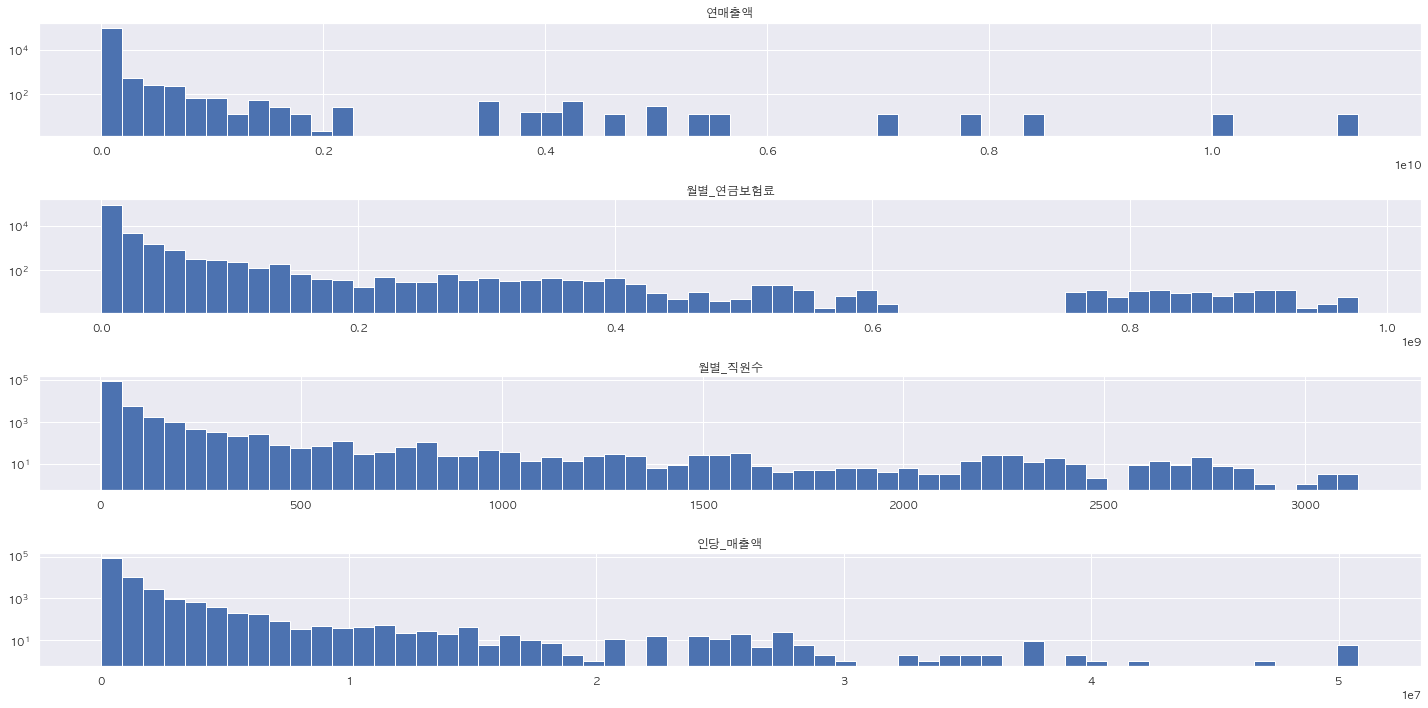

In [5]:
wanted_nps_df.hist(bins=60, column=['연매출액','월별_연금보험료','월별_직원수','인당_매출액'],
                   figsize=(20,10), layout=(4,1), log=True);
plt.tight_layout()

- 히스토그램

> **연매출액/인당매출액 넓게 분포**하여 그룹핑하여 feature

### 매출액 기준 그룹별 경향성 확인

- **3.1의 결과, 넓게 분포한 연매출액/인당매출액 기준으로 binning 하여 feature별 특징파악**

In [111]:
# 위 히스토그램의 영역을 binning하여 그룹핑, 본 작업을 통해 항목 규모별 데이터 분포 및 특징 파악
# binning 작업: 데이터를 값으로 오름차순 정렬하여, 동일한 개수가 되도록 bin 그룹을 나눔
# 전체 Rows를 기준으로 5개의 bin으로 구분
n_bins = 5
wanted_nps_df['연매출액_bin'] = pd.qcut(wanted_nps_df['연매출액'], n_bins, labels=[1,2,3,4,5]) 
wanted_nps_df['인당_매출액_bin'] = pd.qcut(wanted_nps_df['인당_매출액'], n_bins, labels=[1,2,3,4,5]) 
wanted_nps_df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,연매출액_bin,인당_매출액,인당_매출액_bin
0,233757,41688077,2018,7,8912380,36,5,1158002.14,5
1,123464,1760695,2018,3,942380,5,2,352139.00,3
2,342124,3221341,2018,7,781180,4,3,805335.25,5
3,386420,4815584,2015,11,3795900,14,3,343970.29,3
4,129243,9799736,2018,10,40724680,151,4,64898.91,1


#### 연매출액 bin

Text(0.5, 0.98, '연매출액_bin 1 vs 5의 월별_연금보험료와 월별_직원수 박스플롯')

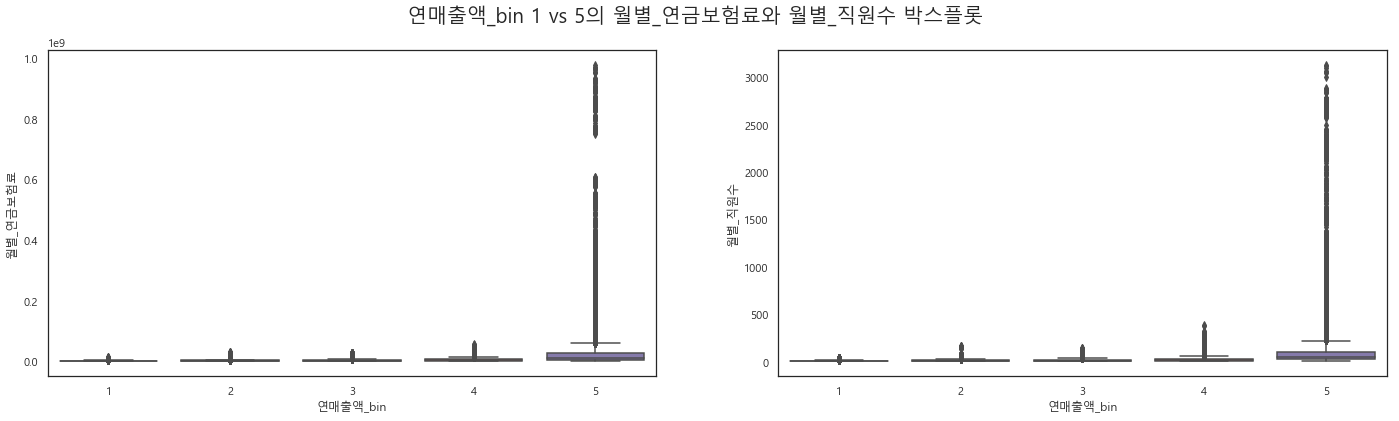

In [105]:
fig, axes = plt.subplots(ncols=2, figsize=(24,6), sharey=False, sharex=True)
sns.boxplot(data=wanted_nps_df, x='연매출액_bin', y='월별_연금보험료', ax=axes[0] )
sns.boxplot(data=wanted_nps_df, x='연매출액_bin', y='월별_직원수', ax=axes[1] )
plt.suptitle('연매출액_bin 1 vs 5의 월별_연금보험료와 월별_직원수 박스플롯', fontsize=20)

Text(0.5, 0.98, '연매출액_bin 1 vs 5의 월별_연금보험료와 연매출액 산점도')

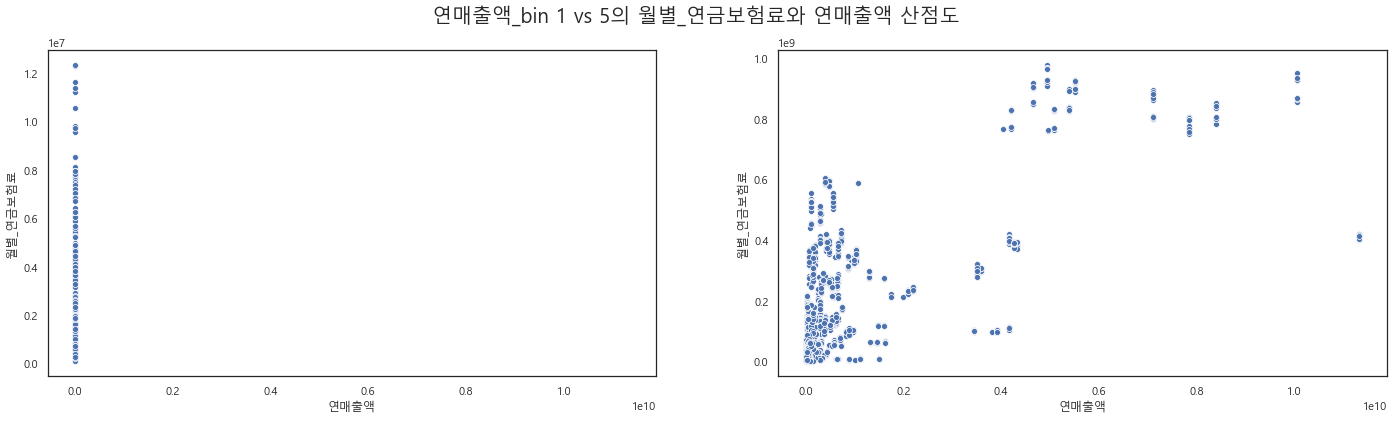

In [120]:
fig, axes = plt.subplots(ncols=2,figsize=(24,6), sharey=False, sharex=True)
sns.scatterplot(data=wanted_nps_df.query('연매출액_bin==1'), x='연매출액', y='월별_연금보험료', ax=axes[0])
sns.scatterplot(data=wanted_nps_df.query('연매출액_bin==5'), x='연매출액', y='월별_연금보험료', ax=axes[1])
plt.suptitle('연매출액_bin 1 vs 5의 월별_연금보험료와 연매출액 산점도', fontsize=20)

Text(0.5, 0.98, '연매출액_bin 1 vs 5의 월별_직원수와 연매출액 산점도')

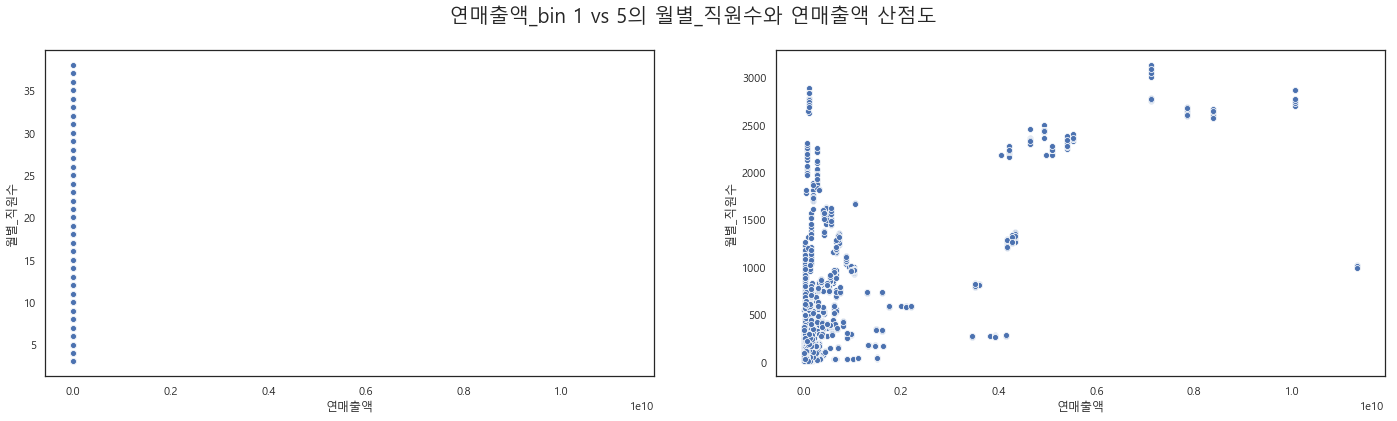

In [119]:
fig, axes = plt.subplots(ncols=2,figsize=(24,6), sharey=False, sharex=True)
sns.scatterplot(data=wanted_nps_df.query('연매출액_bin==1'), x='연매출액', y='월별_직원수', ax=axes[0])
sns.scatterplot(data=wanted_nps_df.query('연매출액_bin==5'), x='연매출액', y='월별_직원수', ax=axes[1])
plt.suptitle('연매출액_bin 1 vs 5의 월별_직원수와 연매출액 산점도', fontsize=20)

#### 인당매출액 bin

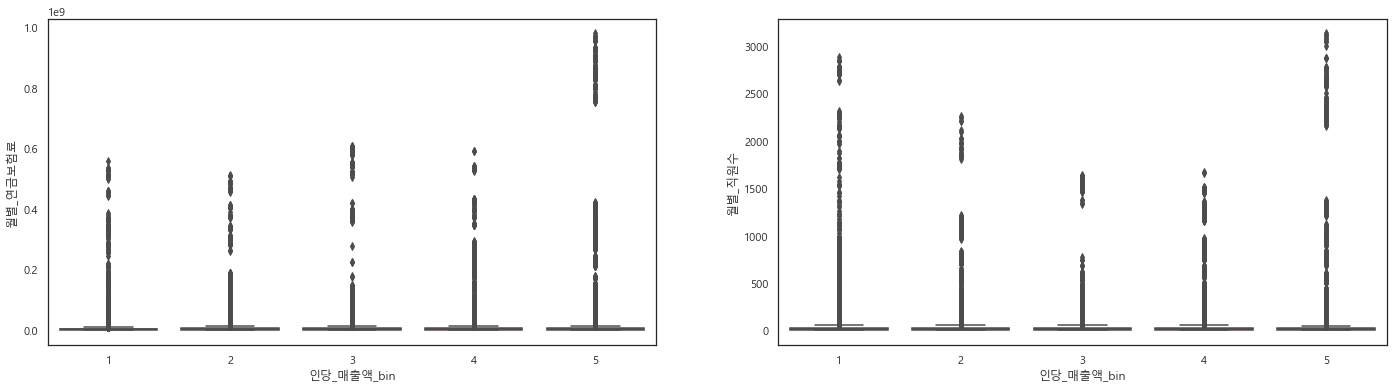

In [89]:
fig, axes = plt.subplots(ncols=2,figsize=(24,6), sharey=False, sharex=True)
sns.boxplot(data=wanted_nps_df, x='인당_매출액_bin', y='월별_연금보험료', ax=axes[0] )
sns.boxplot(data=wanted_nps_df, x='인당_매출액_bin', y='월별_직원수', ax=axes[1] )

Text(0.5, 0.98, '인당_매출액_bin 1 vs 5의 월별_연금보험료와 연매출액 산점도')

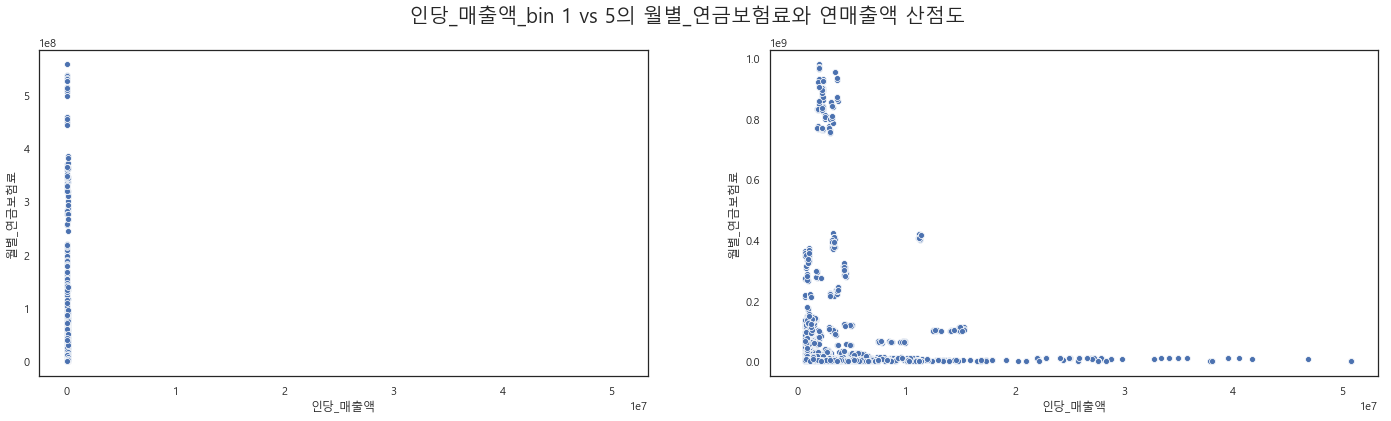

In [117]:
fig, axes = plt.subplots(ncols=2,figsize=(24,6), sharey=False, sharex=True)
sns.scatterplot(data=wanted_nps_df.query('인당_매출액_bin==1'), x='인당_매출액', y='월별_연금보험료',ax=axes[0])
sns.scatterplot(data=wanted_nps_df.query('인당_매출액_bin==5'), x='인당_매출액', y='월별_연금보험료', ax=axes[1])
plt.suptitle('인당_매출액_bin 1 vs 5의 월별_연금보험료와 연매출액 산점도', fontsize=20)

Text(0.5, 0.98, '인당_매출액_bin 1 vs 5의 월별_직원수와 연매출액 산점도')

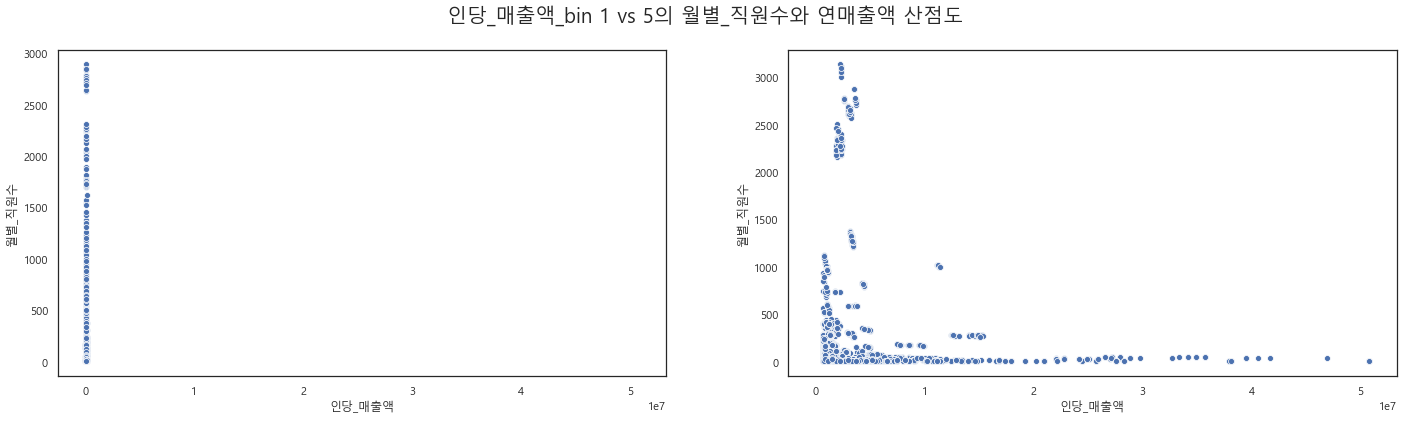

In [116]:
fig, axes = plt.subplots(ncols=2,figsize=(24,6), sharey=False, sharex=True)
sns.scatterplot(data=wanted_nps_df.query('인당_매출액_bin==1'), x='인당_매출액', y='월별_직원수', ax=axes[0])
sns.scatterplot(data=wanted_nps_df.query('인당_매출액_bin==5'), x='인당_매출액', y='월별_직원수', ax=axes[1])
plt.suptitle('인당_매출액_bin 1 vs 5의 월별_직원수와 연매출액 산점도', fontsize=20)

- 특이사항

> **인당매출액** 매출액/직원수로 매출액에서 파생된 변수임에도 월별/직원수, 월별/연금보험료 분포 양상에  **매출액**과 차이 존재 
>
> (매출액은 연단위 직원수는 월단위로 데이터가 존재하기 때문으로 추측됨)

- 박스플롯 

>    **매출액이 높은 그룹(bin = 5)일 수록 월별_연금보험료, 월별_직원수 range가 급격히 넓어짐**

- 산점도 

>    **매출액이 높은 그룹(bin = 5)일 수록 월별_연금보험료, 월별_직원수가 많음**

#### 매출액 필터링 기준

In [157]:
wanted_nps_df.groupby('연매출액_bin').mean().filter(regex='매출|월별')

,연매출액,월별_연금보험료,월별_직원수,인당_매출액
연매출액_bin,,,,
1,614279.94,1171951.85,6.45,115675.64
2,1742160.99,2060841.09,10.11,249913.01
3,3627936.11,3215868.18,14.70,426764.46
4,8084737.32,5713084.41,25.28,646237.51
5,138699839.89,36531817.86,131.67,1534103.80


- 특이사항

> bin 4 vs 5 급격한 차이

- 참고사항

> 유니콘 기업의 등재 시점 기준 당시 연매출액은 1,000억원 이상 (에이프로젠 제외)

- **EDA 1차 결론 & 추가 분석 방향**

>    **매출액** 1000억 초과 시기가 있었던 기업(bin=5 기준 / 실제 유니콘 기업 데이터)만 포함
>
>    **직원수** 1000명 미만 기업 제외 후 EDA 및 지수 산출
>
>    (1000명이상인 경우 이미 성장한 기업으로 판단)

## EDA 2차 
(연매출액이 1,000억원을 초과, 직원이 1,000명 미만의 기업 필터링)

In [121]:
# 분석을 위한 df 세팅
filtered_df = wanted_nps_df.sort_values(['회사ID','년도','월']).reset_index().drop('index', axis=1)

# 한 번이라도 연매출액 1,000억 초과, 직원수 1,000명 미만 회사 목록 출력
filtered_company_list = filtered_df.loc[(filtered_df['연매출액'] > 100000000) & (filtered_df['월별_직원수'] < 1000)].회사ID.unique()    
                                                                    
#추출된 회사 목록의 데이터 전부를 df로 저장
filtered_df = pd.DataFrame()
for id in filtered_company_list:
    
    filtered_df = pd.concat([filtered_df, wanted_nps_df.query(f'회사ID == {id}')]).reset_index().drop('index',axis=1)

filtered_df = filtered_df.astype({'회사ID':str, '년도':str, '월':str})
filtered_df['key'] = filtered_df['회사ID'] + "-" + filtered_df['년도']

print('filtered_df shape :', filtered_df.shape)
print('raw data 기업 수 :', wanted_nps_df['회사ID'].nunique())
print('분석대상금액 필터링 후 기업 수 :', filtered_df['회사ID'].nunique())

filtered_df shape : (2941, 10)
raw data 기업 수 : 4998
분석대상금액 필터링 후 기업 수 : 93


In [124]:
#filtered_df 통계
filtered_df.describe()

,연매출액,월별_연금보험료,월별_직원수,인당_매출액
count,2941.00,2941.00,2941.00,2941.00
mean,429259711.41,91347730.28,298.17,3156156.49
std,948192774.74,98544326.27,299.00,6124336.52
min,188000.00,433060.00,3.00,31333.33
25%,108050157.00,24782660.00,84.00,541279.33
50%,152354246.00,59448460.00,185.00,982130.56
75%,363732805.00,118028860.00,397.00,2595460.06
max,11328779396.00,606774200.00,1932.00,50784748.67


Text(0.5, 0.98, '연매출액&직원수 필터링 후 연매출액_bin 1 vs 5의 연금보험료/직원수/인당매출액 박스플롯')

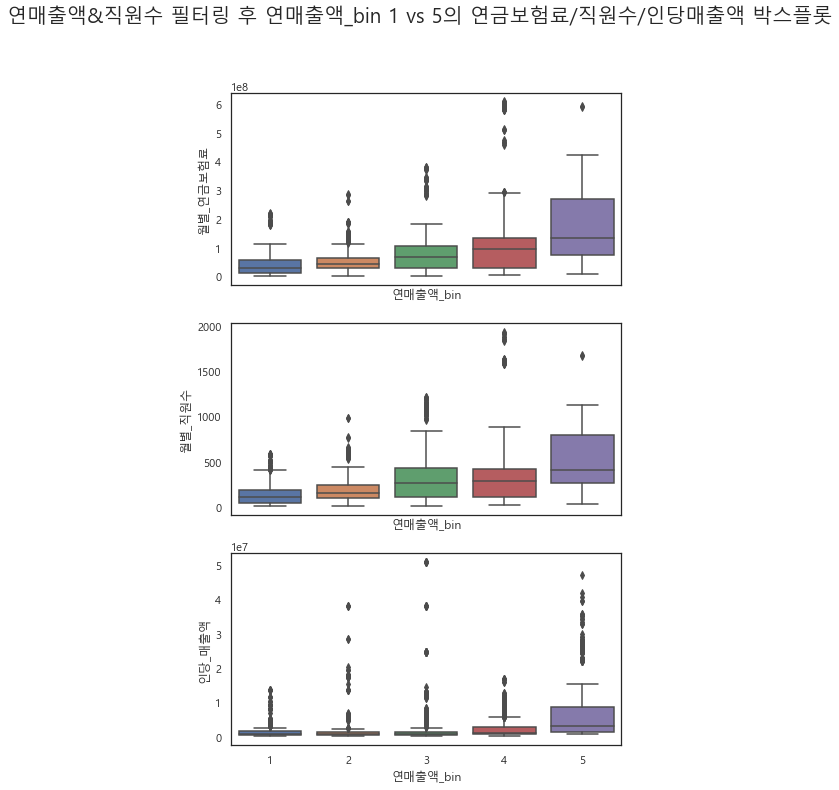

In [178]:
filtered_df_binning= filtered_df.copy()
filtered_df_binning['연매출액_bin'] =pd.qcut(filtered_df_binning['연매출액'], 5, labels=[1,2,3,4,5]) 
fig, axes = plt.subplots(nrows=3, figsize=(7,12), sharey=False, sharex=True)
sns.boxplot(data=filtered_df_binning, x='연매출액_bin', y='월별_연금보험료', ax=axes[0] )
sns.boxplot(data=filtered_df_binning, x='연매출액_bin', y='월별_직원수', ax=axes[1] )
sns.boxplot(data=filtered_df_binning, x='연매출액_bin', y='인당_매출액' , ax=axes[2])
plt.suptitle('연매출액&직원수 필터링 후 연매출액_bin 1 vs 5의 연금보험료/직원수/인당매출액 박스플롯', fontsize=20)

- 필터링 후 박스플롯

> 매출액 양적 성장이 극적으로 증가할수록 상위 50%의 분포가 매우 넓어짐
>
> **연금 보험료의 경우 중위값 상승률이 직원 수보다 뚜렷함**
>
> (연금 보험료의 경우 연봉과 상관관계가 높음. 직원들의 연봉 상승은 매출액, 기업 가치 측면에서 긍정적으로 볼 수 있을 것이라 추측됨. 특히 중위값의 증가는 전체적인 직원의 연봉 상승으로 추측 가능)
>
> 필터링 이전과 달리, **인당_매출액도 매출액이 높은 그룹(bin = 5)일수록 증가하는 양상을 보임**

## Feature Selection 

- 실제 기업 데이터 
> 에이프로젠 제외한 실제 유니콘 기업들은 등재시점 기준 연매출액 1000억 이상 
> 
> ⇒ **한 번이라도 연매출액이 1,000억원을 초과**
>
> 실제 유니콘 기업 연매출액이 폭발적으로 성장한 구간 존재하며, 직원수 연금보험료 또한 상승세 
>
> ⇒ **매출액에 큰 가중치, feature별 성장율**
>
> 중견기업 직원 수 기준 1000명 
>
> ⇒ **월별 직원수가 1,000명 미만인 기업**

- EDA 
> 매출액 양적 성장이 증가할 수록(높은 그룹일수록) 월별_연금보험료, 월별_직원수, 인당_매출액이 많으며, 상위 50%의 분포가 매우 넓어짐
> 
> 월별_연금보험료의 경우 중위값 상승률이 뚜렷하게 파악됨. (연금보험료의 중위값 상승은 연금보험료와 연봉의 상관관계를 고려하여, 전체적인 직원의 연봉상승으로 추측해볼 수 있음)
>
> ⇒ **월별_연금보험료의 경우, 중위값의 성장율을 활용**

### &#128640; 최종 FEATURE SELECTION 결론
**연매출액 성장률, 연 기준 월별 연금보험료 중위값 상승률, 연평균 직원수 상승률, 연평균 1인당 매출액 상승률**의 평균이 급상승한 기업이 유니콘 기업일 것이다.

## &#128640; 유니콘 기업 선정 분석의 방법

1. 연매출액이 1,000억원을 초과하고, 직원수는 1,000명 미만의 기업 필터링
2. **회사별 유니콘 지수(P_unicorn)** 산출 

> 2-1. **연매출 성장률, 연평균 직원수 성장률, 연금보험료 중위값 상승률, 1인당 매출액 상승률** 계산
> 
> 2-2. **2-1의 결과를 binning하여 항목별 스코어링 후 가중치 부여 {P_unicorn} 산출**

3. 유니콘 기업 선정 

> 3-1. 유니콘 지수 기반유니콘 기업 선정
>
> 3-2. Clustering을 통한 4의 결과 cross check 
>
> 3-3. **3-1과 3-2의 결과 교집합 기업을 유니콘기업으로 선정**

### 유니콘 지수 산출 
&#128246; **P_unicorn = (0.5 * P_sales) + (0.2 * P_arpu) + (0.15 * P_pension) + (0.15 * P_employee)**
- 각 항목이 유니콘 기업을 선정하는데 기여하는 정도를 고려하여<br>평가지수 별 가중치를 0.5/0.2/0.15/0.15로 선정<br><br>- 가중치 선정의 이유:<br>- P_sales: 매출 성장은 기업 가치 평가의 가장 중요한 요인이기 때문에 가장 높은 가중치를 부여한다.<br>- P_arpu: 1인당 매출액의 높은 성장률은 기업의 리소스가 효과적으로 활용된다고 가정하여 보다 높은 가중치를 부여한다.<br>- P_pension, P_employee: 월별 연금보험료 중위값 상승과 월별 직원수 상승은 회사의 규모 및 직원의 가치 상승으로 판단하고 동일한 가중치를 부여한다.

#### 유니콘 지수 산출을 위한 df 설계
- 연도별 회사ID의 연매출액 평균, 월별 연금보험료 중위값, 월별 직원수 평균, 인당 매출액 평균을 구한다.
- 비교 대상이 없는 결측치는 제거한다.

In [11]:
# 유니콘 지수 산출을 위한 filtered_df 집계
filtered_agg_df = filtered_df.sort_values('key').groupby('key').agg({'연매출액':'mean',
                                                           '월별_연금보험료':'median',
                                                           '월별_직원수':'mean',
                                                           '인당_매출액':'mean'}).rename(columns = 
                                                                                   {'월별_연금보험료':'월별_연금보험료_중위값',
                                                                                   '월별_직원수':'월평균_직원수',
                                                                                   '인당_매출액':'월평균_인당매출액'})
filtered_agg_df['회사ID'] = pd.DataFrame(filtered_agg_df.reset_index()['key'].str.split('-',2).tolist())[0].tolist()
filtered_agg_df.head()

,연매출액,월별_연금보험료_중위값,월평균_직원수,월평균_인당매출액,회사ID
key,,,,,
102-2018,742658938,173379370,752.12,988296.82,102
126516-2015,1061715908,589243890,1669.00,636144.66,126516
126516-2016,468913812,588353030,1620.25,289412.42,126516
126516-2017,402601664,589826050,1376.58,325600.36,126516
126606-2015,937184426,333420700,998.00,939062.55,126606


In [12]:
growth_df = filtered_agg_df.groupby('회사ID').pct_change().rename(columns = {'연매출액':'연매출액_성장률',
                                                                            '월별_연금보험료_중위값':'월별_연금보험료_성장률',
                                                                            '월평균_직원수':'월평균_직원수_성장률',
                                                                            '월평균_인당매출액':'월평균_인당매출액_성장률'})
# 비교 대상이 없는 결측치 제거
growth_df = growth_df.dropna()
# growth_df 통계 확인
growth_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
연매출액_성장률,214.00,0.35,3.34,-1.00,-0.05,0.05,0.17,46.60
월별_연금보험료_성장률,214.00,0.07,0.22,-0.52,-0.00,0.04,0.11,1.79
월평균_직원수_성장률,214.00,0.03,0.19,-0.45,-0.04,0.02,0.08,1.57
월평균_인당매출액_성장률,214.00,0.37,3.81,-1.00,-0.06,0.03,0.13,53.81


#### 회사별 유니콘 지수 산출
1) 항목별 성장률을 7개로 bining하여 bin별로 Scoring (1~7점 부여)

In [13]:
n_bins = 7
bin_labels = list(range(1,n_bins+1))

for columns in ['연매출액_성장률', '월별_연금보험료_성장률', '월평균_직원수_성장률', '월평균_인당매출액_성장률']:
    new_column = columns.split('_성장률',2)[0] + "_score"
    growth_df.loc[:,new_column] = pd.qcut(growth_df[columns], n_bins, labels=bin_labels)
    
growth_df.sort_values('연매출액_score', ascending = False).head()

,연매출액_성장률,월별_연금보험료_성장률,월평균_직원수_성장률,월평균_인당매출액_성장률,연매출액_score,월별_연금보험료_score,월평균_직원수_score,월평균_인당매출액_score
key,,,,,,,,
433492-2016,0.34,-0.08,-0.12,0.57,7,1,1,7
469677-2017,0.39,0.13,0.20,0.17,7,6,7,6
231384-2017,0.43,-0.19,-0.27,0.93,7,1,1,7
430504-2016,1.10,-0.09,-0.15,1.53,7,1,1,7
231606-2016,0.62,0.07,0.08,0.50,7,5,6,7


2) 항목별 Score에 가중치 부여

In [14]:
f_growth_df = growth_df.astype({'연매출액_score':float,
                                '월별_연금보험료_score':float,
                                '월평균_직원수_score':float,
                                '월평균_인당매출액_score':float})

growth_df['P_sales'] = 0.5 * f_growth_df['연매출액_score']
growth_df['P_arpu'] = 0.2 * f_growth_df['월평균_인당매출액_score']
growth_df['P_pension'] = 0.15 * f_growth_df['월별_연금보험료_score']
growth_df['P_employee'] = 0.15 * f_growth_df['월평균_직원수_score']
growth_df['P_unicorn'] = growth_df['P_sales'] + growth_df['P_arpu'] +growth_df['P_pension'] + growth_df['P_employee']

3) '회사ID'별 최종 평균 점수 만들기

In [15]:
unicorn_df = growth_df.copy().drop(['연매출액_성장률',
                                    '월별_연금보험료_성장률',
                                    '월평균_직원수_성장률',
                                    '월평균_인당매출액_성장률',
                                    '연매출액_score',
                                    '월별_연금보험료_score',
                                    '월평균_직원수_score',
                                    '월평균_인당매출액_score'], axis=1)
unicorn_df['회사ID'] = pd.DataFrame(growth_df.reset_index()['key'].str.split('-',2).tolist())[0].tolist()
unicorn_df = unicorn_df.groupby('회사ID').mean()
ten_unicorn_df = unicorn_df.sort_values('P_unicorn', ascending = False).head(10)

### &#9989; P_unicorn 점수를 기준으로 10개 회사를 선정

In [16]:
ten_unicorn_df

,P_sales,P_arpu,P_pension,P_employee,P_unicorn
회사ID,,,,,
127366,3.33,1.20,0.85,0.85,6.23
420165,3.25,1.30,0.82,0.82,6.20
469677,3.33,1.00,0.85,0.90,6.08
294530,3.00,1.00,1.00,1.00,6.00
420046,3.00,1.20,0.90,0.82,5.92
403470,3.33,0.67,0.95,0.95,5.90
295618,2.83,0.87,0.90,0.90,5.50
232757,2.67,0.93,0.90,0.90,5.40
382850,2.83,0.67,0.80,1.00,5.30


### &#10145; 3. 클러스터링을 통한 선정 기업 Cross Check
-----

#### 클러스터링(Clustering) 

- 클러스터 : 데이터 포인트 (data objects)의 모임으로 같은 그룹(or cluster) 안에서는 서로 비슷하고, 다른 그룹 사이에는 안 비슷한 모양
- 클러스터 분석 또는 클러스터링 (clustering, data segmentation, ...) : 데이터 포인트들을 받아서 그룹들(cluster)로 나누는 것
- 비지도 학습인 클러스터링은 데이터가 어떻게 구성되었는지를 알아내는 문제의 범주에 속한다.
- data set에서 하위그룹(subgroup), 즉 클러스터(cluster)를 찾는 것이다.

#### Hierarchical clustering

* 몇개의 클러스터를 원하는지 모를 때
* 데이터가 dendrogram이라는 트리 모양으로 나타내진다.
* 그 뒤 몇 개의 클러스터를 원하는지 선택한다.
-------
- 출처: https://astralworld58.tistory.com/58

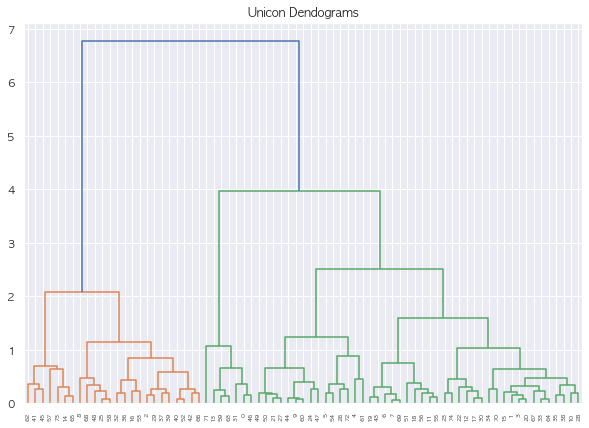

In [17]:
# clustering의 기준: 4개의 Scores
data = unicorn_df.iloc[:,0:4].values

# Dendrograms 시각화
plt.figure(figsize=(10, 7))
plt.title("Unicon Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

 ***Dendrogram을 보고 클러스터를 6개로 구분한다.***

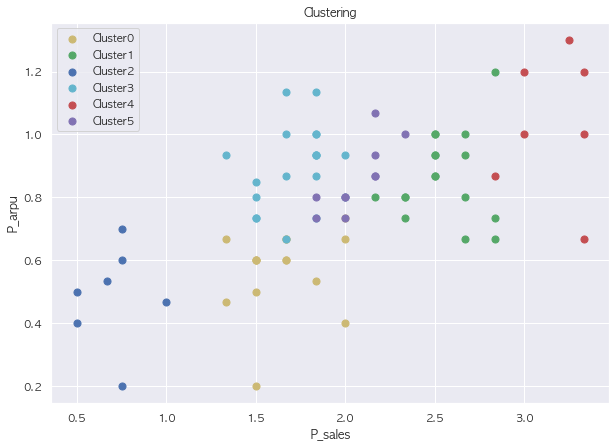

In [18]:
# 클러스터 레이블 확인
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

# 6개 클러스터별 색 구분하여 표시
# P_sales, P_arpu를 축으로 사용
plt.figure(figsize=(10, 7))

plt.scatter(data[cluster.labels_==0, 0], data[cluster.labels_==0, 1], s=50, c='y', label='Cluster0')
plt.scatter(data[cluster.labels_==1, 0], data[cluster.labels_==1, 1], s=50, c='g', label='Cluster1')
plt.scatter(data[cluster.labels_==2, 0], data[cluster.labels_==2, 1], s=50, c='b', label='Cluster2')
plt.scatter(data[cluster.labels_==3, 0], data[cluster.labels_==3, 1], s=50, c='c', label='Cluster3')
plt.scatter(data[cluster.labels_==4, 0], data[cluster.labels_==4, 1], s=50, c='r', label='Cluster4')
plt.scatter(data[cluster.labels_==5, 0], data[cluster.labels_==5, 1], s=50, c='m', label='Cluster5')

plt.title('Clustering')
plt.xlabel('P_sales')
plt.ylabel('P_arpu')
plt.legend()
plt.show()

In [19]:
# Dendrograms으로 분류된 클러스터, 기존 df에 추가
cluster_df = pd.DataFrame([unicorn_df.index.tolist(),list(cluster.labels_)]).transpose()
cluster_df.columns = ['회사ID', 'Cluster']
unicorn_cluster_df = pd.merge(unicorn_df, cluster_df, left_on=unicorn_df.index, right_on='회사ID', how='inner')

#### &#10004; ***유니콘 기업 선정***

In [20]:
# 클러스터의 가장 우상향에 있는 4번 클러스터 필터링
unicorn_cluster_df = unicorn_cluster_df.query('Cluster == 4')
unicorn_cluster_df.sort_values('P_unicorn', ascending=False)

,P_sales,P_arpu,P_pension,P_employee,P_unicorn,회사ID,Cluster
14,3.33,1.20,0.85,0.85,6.23,127366,4
65,3.25,1.30,0.82,0.82,6.20,420165,4
73,3.33,1.00,0.85,0.90,6.08,469677,4
41,3.00,1.00,1.00,1.00,6.00,294530,4
62,3.00,1.20,0.90,0.82,5.92,420046,4
57,3.33,0.67,0.95,0.95,5.90,403470,4
45,2.83,0.87,0.90,0.90,5.50,295618,4


In [21]:
pick_unicorn_df = pd.merge(unicorn_cluster_df, ten_unicorn_df, on='회사ID', how = 'inner')
pick_unicorn_df.drop(['P_sales_x',
                      'P_arpu_x',
                      'P_pension_x',
                      'P_employee_x',
                      'P_unicorn_x',
                      'Cluster',
                      'P_sales_y',
                      'P_arpu_y',
                      'P_pension_y',
                      'P_employee_y'], axis=1).rename(columns=({'P_unicorn_y' : 'P_unicorn'})).sort_values('P_unicorn', ascending=False)

,회사ID,P_unicorn
0,127366,6.23
5,420165,6.20
6,469677,6.08
1,294530,6.00
4,420046,5.92
3,403470,5.90
2,295618,5.50


## &#128640; 2차 분석 결과 선정된 유니콘 기업 List (P_score와 클러스터링 결과의 교집합)
### - 127366 (6.23)
### - 420165 (6.20)
### - 469677 (6.08)
### - 294530 (6.00)
### - 420046 (5.92)
### - 403470 (5.90)
### - 295618 (5.50)

![선정 기업 시각화](https://i.esdrop.com/d/FZOd4SBQWQ.png)